In [ ]:

from dataset_helpers import DiabetesDataset
from model_helpers import *

In [20]:
agent = train_saccql(dataset_path="datasets/processed/full-training.csv",use_cql=True,cql_alpha=0.1)

Checkpoint saved: modelSACCQL_epoch_50.pt
Checkpoint saved: modelSACCQL_epoch_100.pt
Checkpoint saved: modelSACCQL_epoch_150.pt
Checkpoint saved: modelSACCQL_epoch_200.pt


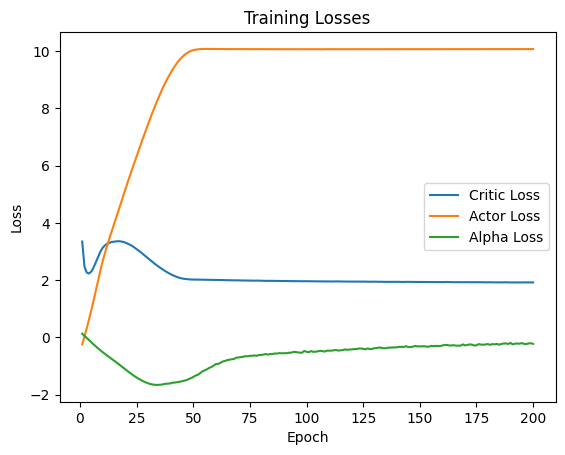

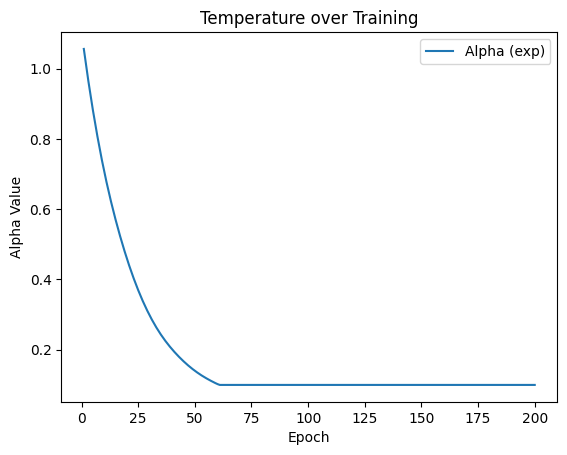

In [21]:
plot_training_metrics(csv_file="training_metricsSACCQL.csv")

Offline Evaluation (test set):
  Average Q(s, pi(s)): -9.9713
  Predicted Actions -> mean: -0.3353, std: 0.1551
  Actual Actions    -> mean: -0.3082, std: 0.2077
  MSE between predicted and actual actions: 0.0175
  Pearson Correlation: 0.7830
  R^2 Score: 0.5947
  KS-Test: statistic=0.0843, p-value=0.0000
  Linear Regression: slope=0.5847, intercept=-0.1551


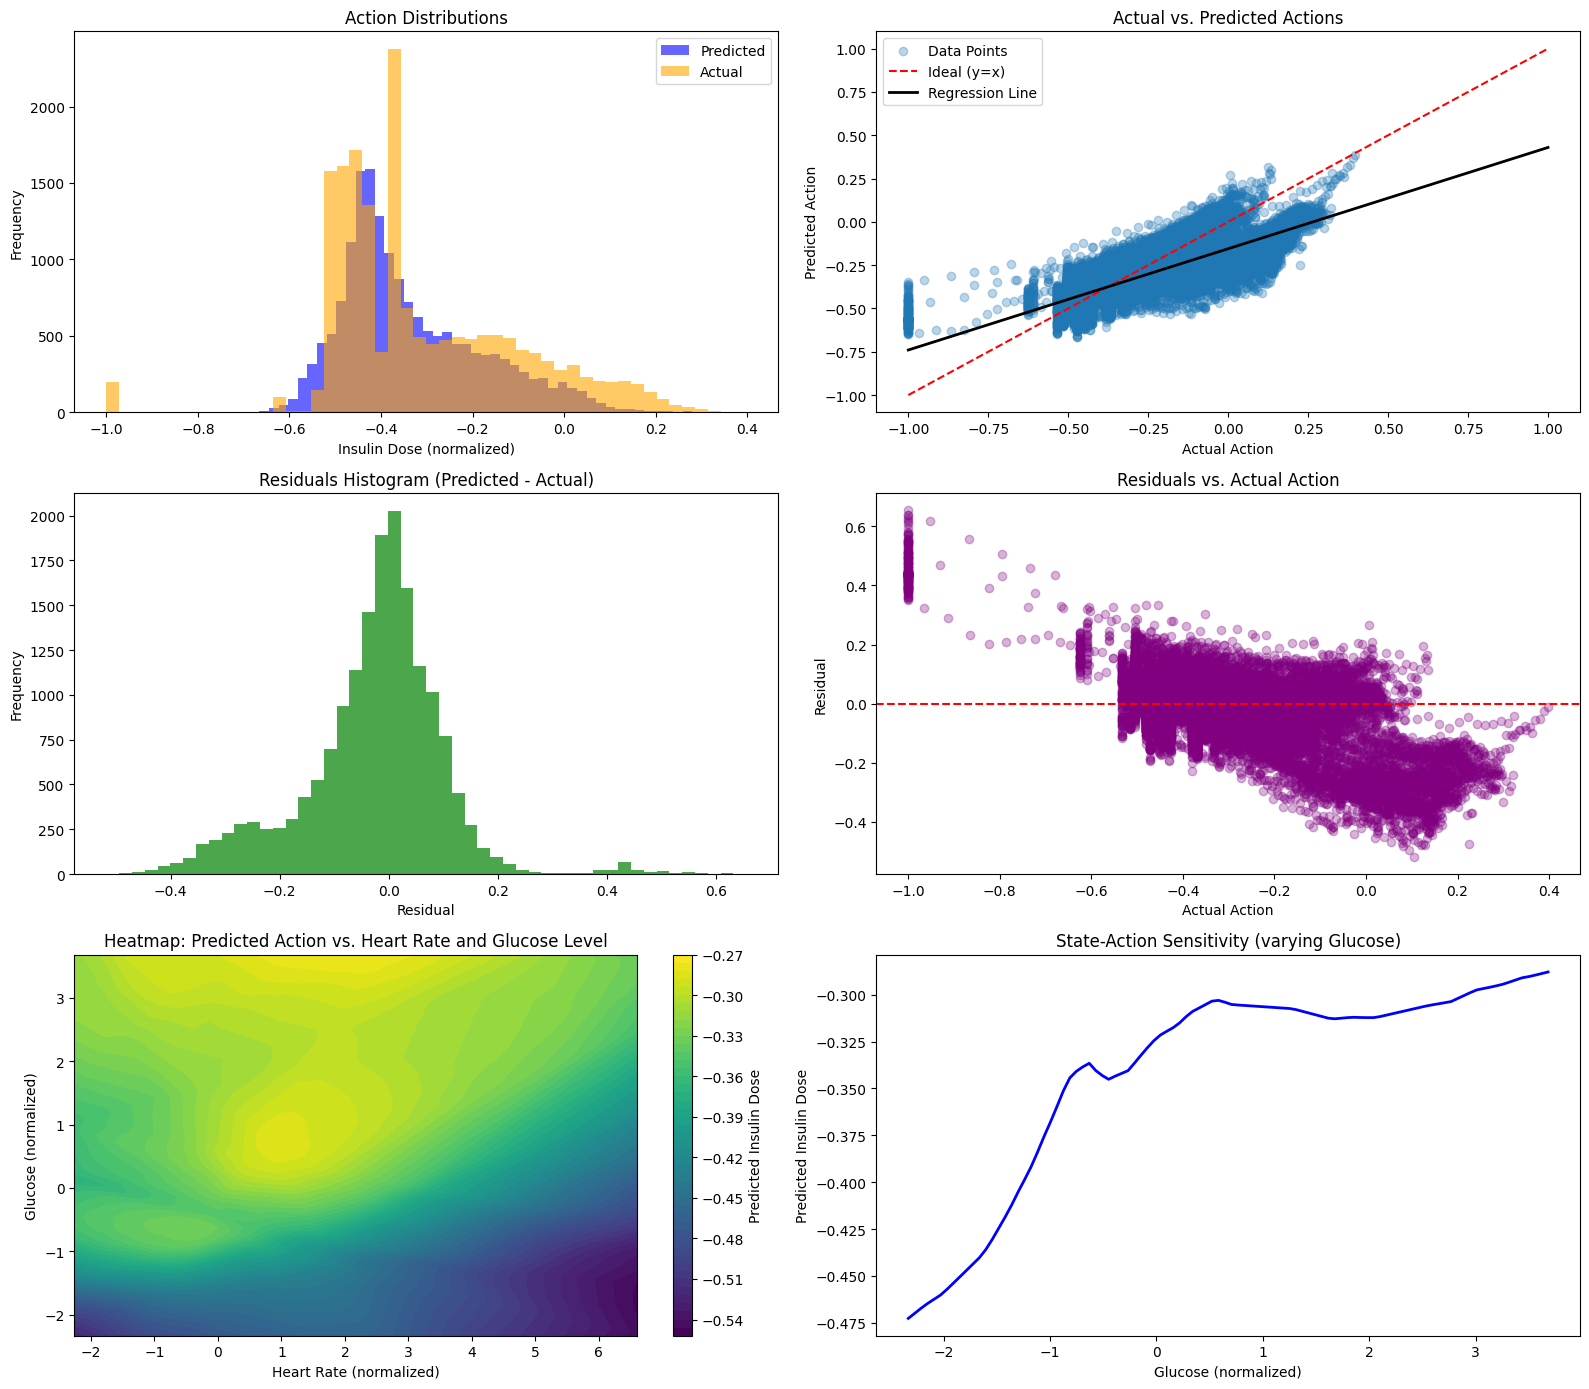

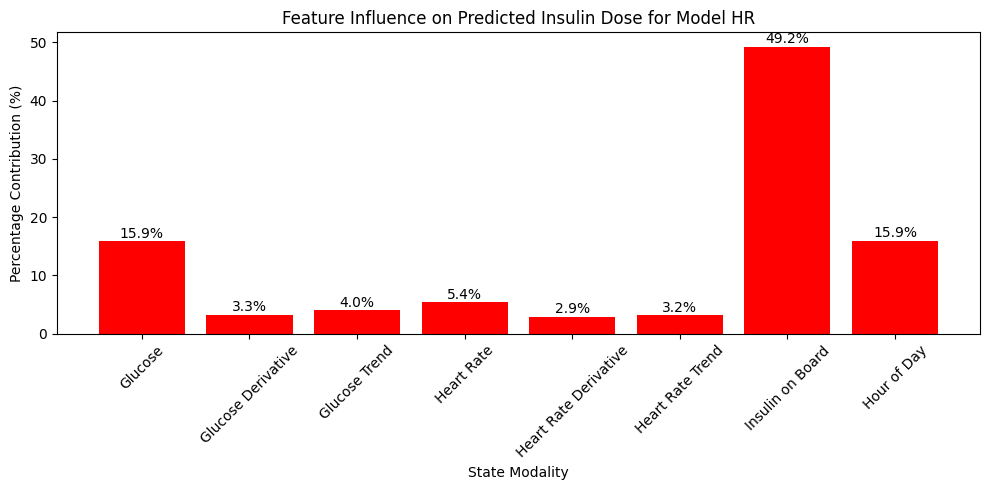

In [ ]:
evaluate_policy("modelSACCQL_epoch_200.pt", "datasets/processed/full-testing.csv", device='cpu', batch_size=256)

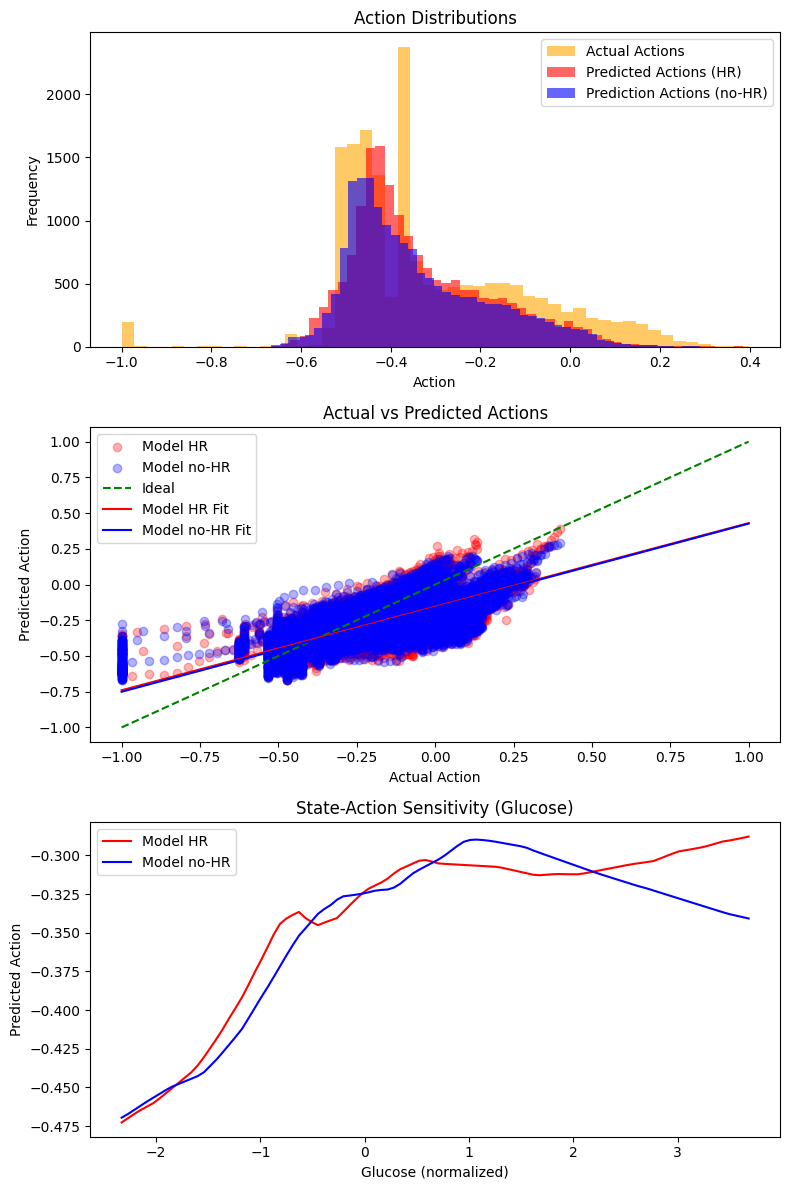


Model 1 Evaluation:
  Avg Q: -9.9713
  MSE: 0.0175
  Pearson Correlation: 0.7830
  R² Score: 0.5947
  Regression Line: slope=0.5847, intercept=-0.1551

Model 2 Evaluation:
  Avg Q: -9.9678
  MSE: 0.0178
  Pearson Correlation: 0.7856
  R² Score: 0.5875
  Regression Line: slope=0.5884, intercept=-0.1618


In [116]:
compare_two_models("modelSACCQL_epoch_200.pt", "modelSACCQL_noHR_epoch_200.pt", "datasets/processed/full-testing.csv")
